In [1]:
%matplotlib inline

In [6]:
import os
import requests
import numpy as np
import pandas as pd
from io import BytesIO  # Python 3 only!
import matplotlib.pyplot as pl


def get_catalog(name, basepath="data"):
    """
    Download a catalog from the Exoplanet Archive by name and save it as a
    Pandas HDF5 file.

    :param name:     the table name
    :param basepath: the directory where the downloaded files should be saved
                     (default: ``data`` in the current working directory)

    """
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

In [94]:
stlr = get_catalog("q1_q17_dr24_stellar")

# Select the stars.
trng = (5300.0, 6000.0)
logg = (4.0, 10000.0)
m = np.isfinite(stlr.teff) & (trng[0] <= stlr.teff) & (stlr.teff < trng[1])
m &= np.isfinite(stlr.logg) & (logg[0] <= stlr.logg) & (stlr.logg < logg[1])

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 30.0
m &= stlr.dutycycle > 0.1

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)
stlr = pd.DataFrame(stlr[m])
print("Selected {0} targets after cuts".format(len(stlr)))

Selected 64781 targets after cuts


In [137]:
kois = get_catalog("q1_q17_dr24_koi")

# Select candidates.
period_rng = (40, 80)
rp_rng = (1.5, 2.3)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid", "teff", "radius"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period < period_rng[1])
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad < rp_rng[1])
m &= np.isfinite(kois.koi_max_mult_ev) & (kois.koi_max_mult_ev > 15.0)

kois = pd.DataFrame(kois[m])
print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 25 KOIs after cuts


In [ ]:
kois.koi_srad

In [140]:
kois[["koi_steff", "teff", "koi_srad", "radius"]]

,koi_steff,teff,koi_srad,radius
35,5529,5376,0.832,0.940
295,5741,5695,1.008,0.839
548,5601,5601,0.830,0.830
1162,5627,5627,1.056,1.056
1406,5893,5893,0.866,0.866
1484,6038,5670,0.922,0.950
1528,5857,5857,1.364,1.364
1539,5871,5871,1.703,1.703
1709,5465,5465,0.736,0.736
1815,5968,5968,0.881,0.881


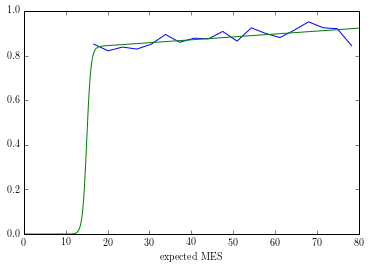

In [148]:
inj = pd.read_csv("data/DR24-Pipeline-Detection-Efficiency-Table.txt", delim_whitespace=True,
                  skiprows=4, header=None, names=[
                    "kepid", "sky", "period", "epoch", "t_depth", "t_dur", "t_b", "t_ror", "t_aor",
                    "offset_from_source", "offset_distance", "expect_mes", "recovered", "meas_mes",
                    "r_period", "r_epoch", "r_depth", "r_dur", "r_b", "r_ror", "r_aor"
                  ])

# Join on the stellar list.
inj = pd.merge(inj, stlr[["kepid"]], on="kepid", how="inner")

# Estimate the linear trend above 15 MES.
mesthresh = 15
maxmes = 80
m = (inj.expect_mes > mesthresh) & (inj.expect_mes < maxmes)
bins = np.linspace(mesthresh, maxmes, 20)
n_tot, _ = np.histogram(inj.expect_mes[m], bins)
m &= inj.recovered
n_rec, _ = np.histogram(inj.expect_mes[m], bins)

x = 0.5 * (bins[:-1] + bins[1:])
y = n_rec / n_tot
m = np.isfinite(y)
x, y = x[m], y[m]

comp_p = np.polyfit(x, y, 1)
pl.plot(x, y)

x0 = np.linspace(0, 80, 500)
pl.plot(x0, np.polyval(comp_p, x0) / (1 + np.exp(-2*(x0-mesthresh))))
pl.xlabel("expected MES");

In [152]:
def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    y = np.polyval(comp_p, mes) / (1 + np.exp(-2*(mes-mesthresh)))
    y[y > 1.0] = 1.0
    return y

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

In [153]:
# # Choose the star.
# star = stlr[stlr.kepid == 10593626].iloc[0]

# # Compute the completeness map on a grid.
# period = np.linspace(10, 700, 500)
# rp = np.linspace(0.5, 2.5, 421)
# X, Y = np.meshgrid(period, rp, indexing="ij")
# Z = get_completeness(star, X, Y, 0.0, with_geom=False)

# # Plot with the same contour levels as the figure.
# c = pl.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
# pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
# pl.xlabel("period [days]")
# pl.ylabel("$R_p \, [R_\oplus]$")
# pl.title("det. eff. for KIC10593626");

In [154]:
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)

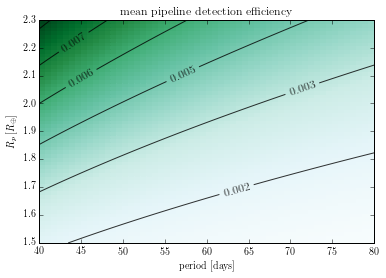

In [155]:
pl.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
c = pl.contour(period_grid, rp_grid, comp / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

In [175]:
area = np.diff(np.log(period))[0] * np.diff(np.log(rp))[0]
Q = float(np.sum(comp * area) / (np.diff(np.log(period_rng)) * np.diff(np.log(rp_rng))))
N = len(kois)
occ = N / Q
sig = occ / np.sqrt(N)

In [176]:
occ

0.06629080539769654

In [177]:
Q / len(stlr)

0.005821555811441504

In [178]:
print("{0:.2} ± {1:.2}".format(occ, sig))

0.066 ± 0.013
